In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import tensorflow.keras.backend as K
from tensorflow.keras.utils import Sequence, to_categorical
from tensorflow.keras.preprocessing.image import *

from tensorflow.keras.callbacks import *
from tensorflow.keras.losses import *
from tensorflow.keras.optimizers import *

from sklearn.model_selection import train_test_split,StratifiedKFold

import glob
import os

In [2]:
image_shape = (120,160,3)

# Model

In [3]:
from model import *
model = MODEL(image_shape)

W0829 14:32:12.296659  8532 deprecation_wrapper.py:119] From C:\Users\Yap Seng Kuang\Desktop\japanese\gym-duckietown\learning\model.py:29: The name tf.keras.initializers.he_normal is deprecated. Please use tf.compat.v1.keras.initializers.he_normal instead.

W0829 14:32:13.800745  8532 lazy_loader.py:50] 
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

W0829 14:32:13.860749  8532 deprecation.py:506] From c:\users\yap seng kuang\appdata\local\programs\python\python36\lib\site-packages\tensorflow\python\ops\init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for up

In [4]:
# model.summary()

In [4]:
graph = K.get_session().graph
writer = tf.summary.FileWriter(logdir="./logs/", graph=graph)

## open cmd and type below  
*>>>tensorboard --logdir ./logs/  
http://localhost:6006/

# Train Validation Split

In [5]:
all_images = glob.glob("data/*")
all_images[:10]

['data\\20190829142531_00000_3.png',
 'data\\20190829142531_00001_3.png',
 'data\\20190829142531_00002_3.png',
 'data\\20190829142531_00003_3.png',
 'data\\20190829142531_00004_3.png',
 'data\\20190829142531_00005_3.png',
 'data\\20190829142531_00006_3.png',
 'data\\20190829142531_00007_3.png',
 'data\\20190829142531_00008_3.png',
 'data\\20190829142531_00009_3.png']

In [8]:
# for f in all_images:
#     new = f.split(".")[-2][:-1]+str(int(f.split(".")[-2][-1]) - 1 )
#     os.rename(f,new+".png")

In [6]:
labels = [i.split(".")[-2].split("_")[-1] for i in all_images]

In [7]:
df = pd.DataFrame({"file_name":all_images,"labels":labels})

In [8]:
df.head()

,file_name,labels
0,data\20190829142531_00000_3.png,3
1,data\20190829142531_00001_3.png,3
2,data\20190829142531_00002_3.png,3
3,data\20190829142531_00003_3.png,3
4,data\20190829142531_00004_3.png,3


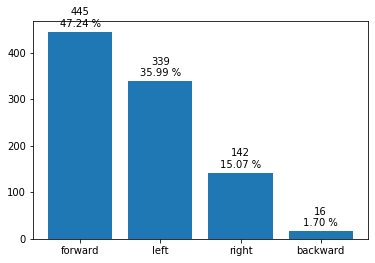

In [9]:
def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    total = 0
    for rect in rects:
        total += rect.get_height()
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height}\n{height/total*100:.2f} %',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')
        
fig, ax = plt.subplots()
rect = ax.bar(["forward","left","right","backward"],df.labels.value_counts())
autolabel(rect)
plt.show()

In [10]:
train_fn,val_fn = train_test_split(df,stratify=df.labels,test_size=0.1,random_state=10)

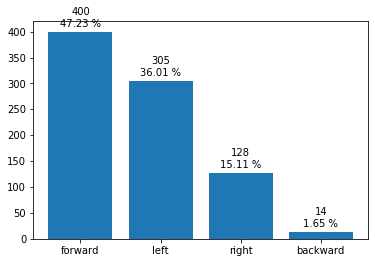

In [11]:
fig, ax = plt.subplots()
rect = ax.bar(["forward","left","right","backward"],train_fn.labels.value_counts())
autolabel(rect)
plt.show()

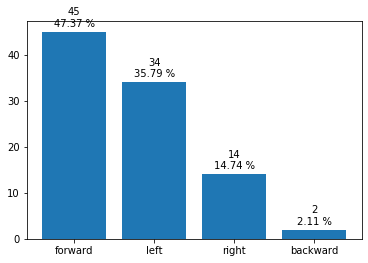

In [12]:
fig, ax = plt.subplots()
rect = ax.bar(["forward","left","right","backward"],val_fn.labels.value_counts())
autolabel(rect)
plt.show()

In [13]:
train_fn.reset_index(drop=True,inplace=True)
val_fn.reset_index(drop=True,inplace=True)

# DataGenerator

In [14]:
class DataGenerator(Sequence):
    def __init__(self,df,batch_size=64):
        self.df = df
        self.batch_size = batch_size
        self.indexes = np.arange(len(self.df))
        self.on_epoch_end()
        
    def __len__(self):
        return int(np.ceil(len(self.df)/float(self.batch_size)))
    
    def __getitem__(self,idx):
        indexes  = self.indexes[idx*self.batch_size:(idx+1)*self.batch_size]
        current_batch_size = len(indexes)
        x = np.zeros((current_batch_size,*image_shape))
        y = np.zeros((current_batch_size,4))
        for i,p in enumerate(indexes):
            x[i,...] = img_to_array(load_img(self.df.file_name[p]))
            y[i,...] = to_categorical(self.df.labels[p],num_classes=4)
           
        return x,y
        
    def on_epoch_end(self):
        np.random.shuffle(self.indexes)

# Test generator

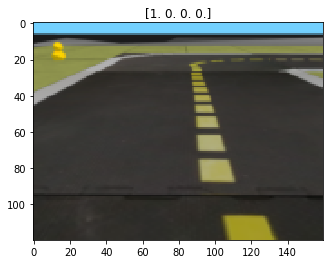

In [16]:
a = DataGenerator(train_fn,10)
temp,lbl = a.__getitem__(10)
plt.imshow(temp[0][::-1,...].astype(np.uint8))
plt.title(lbl[0])
plt.show()

In [17]:
%%time
callbacks = [ModelCheckpoint("checkpoints/Model-Best.h5", monitor="val_acc",mode = "max",save_best_only=True, save_weights_only=True,verbose=1),
            ReduceLROnPlateau(monitor='val_acc', factor=0.1,patience=3, min_lr=0, mode='max', verbose=1),
            EarlyStopping(monitor='val_acc', patience=20,verbose=1, mode='max')]

Wall time: 0 ns


In [18]:
model.compile(optimizer = Adam(1e-3),loss="categorical_crossentropy",metrics=["acc"])

In [19]:
history = model.fit_generator(generator=DataGenerator(train_fn,batch_size=16),
                              validation_data = DataGenerator(val_fn,batch_size=16),
                              epochs = 100,
                              verbose = 1,
                              callbacks = callbacks)

Epoch 1/100
52/53 [============================>.] - ETA: 0s - loss: 99.2087 - acc: 0.5548 
Epoch 00001: val_acc improved from -inf to 0.65263, saving model to checkpoints/Model-Best.h5
53/53 [==============================] - 28s 527ms/step - loss: 97.7630 - acc: 0.5584 - val_loss: 22.8654 - val_acc: 0.6526
Epoch 2/100
52/53 [============================>.] - ETA: 0s - loss: 10.2019 - acc: 0.7798
Epoch 00002: val_acc improved from 0.65263 to 0.73684, saving model to checkpoints/Model-Best.h5
53/53 [==============================] - 25s 473ms/step - loss: 10.2814 - acc: 0.7792 - val_loss: 8.1619 - val_acc: 0.7368
Epoch 3/100
52/53 [============================>.] - ETA: 0s - loss: 6.4826 - acc: 0.8099
Epoch 00003: val_acc improved from 0.73684 to 0.85263, saving model to checkpoints/Model-Best.h5
53/53 [==============================] - 27s 501ms/step - loss: 6.4290 - acc: 0.8099 - val_loss: 8.2208 - val_acc: 0.8526
Epoch 4/100
52/53 [============================>.] - ETA: 0s - loss: 5

# Check graphs

Text(0.5, 1.0, 'model loss')

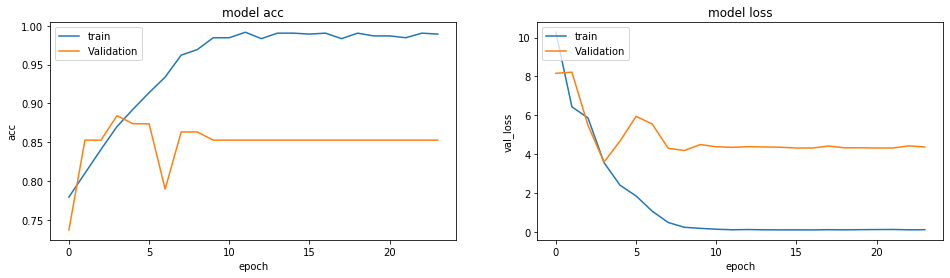

In [20]:
plt.figure(figsize=(16,4))
plt.subplot(1,2,1)
plt.plot(history.history['acc'][1:])
plt.plot(history.history['val_acc'][1:])
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train','Validation'], loc='upper left')

plt.title('model acc')

plt.subplot(1,2,2)
plt.plot(history.history['loss'][1:])
plt.plot(history.history['val_loss'][1:])
plt.ylabel('val_loss')
plt.xlabel('epoch')
plt.legend(['train','Validation'], loc='upper left')
plt.title('model loss')


# Load the best model

In [21]:
model.load_weights("checkpoints/Model-Best.h5")

# Predict one images

True labels:left//Predict labels:left


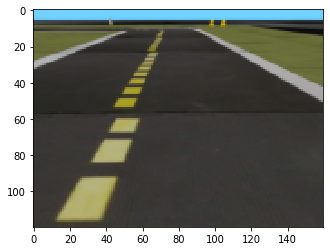

In [27]:
actions = ["forward","left","right","backward"]
idx = np.random.randint(0,len(val_fn))
file_name = val_fn.iloc[idx].file_name
labels = val_fn.iloc[idx].labels
img = img_to_array(load_img(file_name))
pred = model.predict(np.expand_dims(img,axis=0))
print(f"True labels:{actions[int(labels)]}//Predict labels:{actions[np.argmax(pred)]}")
plt.imshow(img[::-1,:,:].astype(np.uint8))
plt.show()